In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Project inspired from this paper
**<a href= "https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment"> DeepFood</a>**

### Get helper functions

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-18 09:42:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-18 09:42:47 (55.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Tensoflow Datasets

In [8]:
import tensorflow_datasets as tfds

In [9]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteTWNZBD/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteTWNZBD/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [10]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 dataset

In [12]:
train_one_sample = train_data.take(1)

In [13]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 23
  Class name (str form): churros
        


In [16]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

### Plot an image from tensorflow dataset

In [17]:
import matplotlib.pyplot as plt

(-0.5, 511.5, 511.5, -0.5)

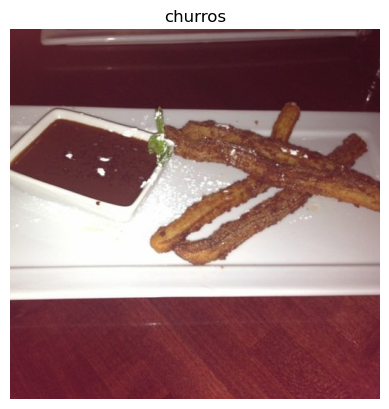

In [18]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

### Creating preprocessing functions

In [19]:
def preprocess_img(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [20]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]

 [[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[93.       34.       40.      ]
  [94.       35.       41.      ]
  [95.       36.       42.      ]
  ...
  [55.       15.       24.      ]
  [52.       15.       23.      ]
  [52.       15.       23.      ]]

 [[93.92857  34.928574 40.928574]
  [93.07143  34.071426 40.071426]
  [94.       35.       41.      ]
  ...
  [55.       15.       24.      ]
  [54.       14.       23.      ]
  [52.       15.       23.      ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


### Batch and Prepare datsets

In [21]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Create modelling callbacks

In [23]:
from helper_functions import create_tensorboard_callback

In [24]:
checkpoint_path = "model_checkpoints/cp.ckpt"

In [25]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_accuracy",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)

### Setup mixed precision training

In [26]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [27]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Build feature extraction model

In [28]:
from tensorflow.keras import layers

In [29]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [30]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Fitting the extration model

In [32]:
history_0 = model.fit(train_data,
                     epochs=5,
                     validation_data=test_data,
                     validation_steps=int(0.15 * len(test_data)),
                     callbacks=[create_tensorboard_callback("training_logs", 
                                                            "efficientnetb0_101_classes_all_data_feature_extract"), 
                                model_checkpoint]) 

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230618-095437
Epoch 1/5
2368/2368 [==============================] - 197s 76ms/step - loss: 1.7143 - accuracy: 0.5825 - val_loss: 1.1273 - val_accuracy: 0.7002
Epoch 2/5
2368/2368 [==============================] - 179s 74ms/step - loss: 1.1989 - accuracy: 0.6892 - val_loss: 1.0404 - val_accuracy: 0.7140
Epoch 3/5
2368/2368 [==============================] - 187s 78ms/step - loss: 1.0538 - accuracy: 0.7259 - val_loss: 0.9858 - val_accuracy: 0.7264
Epoch 4/5
2368/2368 [==============================] - 193s 81ms/step - loss: 0.9584 - accuracy: 0.7480 - val_loss: 0.9804 - val_accuracy: 0.7346
Epoch 5/5
2368/2368 [==============================] - 174s 73ms/step - loss: 0.8891 - accuracy: 0.7658 - val_loss: 0.9756 - val_accuracy: 0.7317


In [33]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 54s 68ms/step - loss: 0.9755 - accuracy: 0.7348


[0.9754523634910583, 0.734772264957428]

In [34]:
def create_model():
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape, name="input_layer")

    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = layers.Dense(len(class_names))(x)

    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [35]:
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

created_model.load_weights(checkpoint_path)

results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 55s 66ms/step - loss: 0.9832 - accuracy: 0.7315


In [36]:
# import numpy as np
# assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

AssertionError: Loaded weights results are not close to original model.

### Saving model

In [ ]:
# save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
# model.save(save_dir)

In [ ]:
# loaded_saved_model = tf.keras.models.load_model(save_dir)

### Important callbaks

In [42]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_best_only=True,
                                                     monitor="val_loss")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.2,
                                                patience=2,
                                                verbose=1,
                                                min_lr=1e-7)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

### Fine tuning

In [38]:
for layer in created_model.layers:
    layer.trainable = True

In [39]:
created_model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(0.0001),
                    metrics=["accuracy"])

In [44]:
finetune_history_0 = created_model.fit(train_data,
                                      epochs=100,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"),
#                                                 model_checkpoint,
                                                early_stopping,
                                                reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230618-110220
Epoch 1/100
2368/2368 [==============================] - 368s 154ms/step - loss: 0.1078 - accuracy: 0.9668 - val_loss: 0.9881 - val_accuracy: 0.7839 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 367s 154ms/step - loss: 0.0815 - accuracy: 0.9737 - val_loss: 1.0961 - val_accuracy: 0.7834 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9788
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 371s 156ms/step - loss: 0.0677 - accuracy: 0.9788 - val_loss: 1.1297 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 368s 155ms/step - loss: 0.0131 - accuracy: 0.9970 - val_loss: 1.1349 - val_accuracy: 0.8024 - lr: 2.0000e-05
